In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner
#Modeling tools
exec(open('tools/modeling.py').read())
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Descriptors import MolLogP
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import Descriptors
import sys
import multiprocessing
from standardiser import break_bonds, neutralise, rules, unsalt
from standardiser.utils import StandardiseException, sanity_check
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from sklearn.externals import joblib


import sys
def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn
#Modeling tools
exec(open('tools/modeling.py').read())
from rdkit.Chem.Descriptors import MolLogP
from rdkit.Chem import Descriptors
from tools import tools
from tools import  pipeline as p
from tools import  sar
from sklearn.metrics import cohen_kappa_score
import csv
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import ShuffleSplit
import _pickle as cPickle
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
import bz2
from glob import glob
import _pickle as cPickle
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import train_test_split

 # Acute Inhalation

##  Acute Inhalation - Morgan

In [19]:
acute_inhalation = joblib.load('Projeto_7_Skin_sensitization/model/Modelo_Skin_Sens_morgan.pkl')
acute_inhalation_data= pd.read_pickle('Projeto_7_Skin_sensitization/model/Dados_adicionais_Skin_Sens_morgan.pbz2', compression="bz2")
moldf= acute_inhalation_data['molDF']
del moldf['mol']
moldf.head()

,Outcome,Prediction,Confiability
SMILES,,,
BrC1CC(Br)CC(Br)CC(Br)CC(Br)CC(Br)C1,0,Sensitizer,57.138095
BrCCBr,0,Sensitizer,56.631019
BrCCc1ccccc1,1,Sensitizer,66.569231
BrCc1ccccc1,1,Sensitizer,74.800000
C#CC(O)CCCCC,1,Sensitizer,50.786667


In [20]:
#
moldf['Outcome']=np.where(moldf['Outcome'] >= '1', 1, -1)
moldf['Prediction']=np.where(moldf['Prediction']== 'Sensitizer', 1, -1)
moldf['Confiability']= moldf['Confiability'].values/100
#
moldf_acute_inhalation = moldf.copy()
#del moldf_acute_inhalation['Outcome']
moldf_acute_inhalation = moldf_acute_inhalation.rename(columns={"Prediction": "Morgan_Pred", "Confiability": "Morgan_Conf"})
fps_acute_inhalation_morgan= np.vstack(acute_inhalation_data['fpDF']['FingerPrint'].values)
X, y = train_test_split( fps_acute_inhalation_morgan , test_size=0.2, random_state=42)
acute_inhalation_morgan_AD_limit= (np.average(acute_inhalation_data['applM'])-(1*(np.std(acute_inhalation_data['applM']))))
acute_inhalation_morgan_K= acute_inhalation_data["k"]
acute_inhalation_morgan_AD = getNeighborsDitance(X,fps_acute_inhalation_morgan , acute_inhalation_morgan_K)
moldf_acute_inhalation['Morgan AD']= np.where(acute_inhalation_morgan_AD >=acute_inhalation_morgan_AD_limit, 1, 0)
moldf_acute_inhalation.head()

,Outcome,Morgan_Pred,Morgan_Conf,Morgan AD
SMILES,,,,
BrC1CC(Br)CC(Br)CC(Br)CC(Br)CC(Br)C1,-1,1,0.571381,0
BrCCBr,-1,1,0.566310,1
BrCCc1ccccc1,1,1,0.665692,1
BrCc1ccccc1,1,1,0.748000,1
C#CC(O)CCCCC,1,1,0.507867,1


In [21]:
moldf_acute_inhalation['Morgan Pred'] = moldf_acute_inhalation[['Morgan_Pred', 'Morgan_Conf']].prod(1)
moldf_acute_inhalation['Morgan Pred AD'] = moldf_acute_inhalation[['Morgan_Pred', 'Morgan_Conf','Morgan AD']].prod(1)
moldf_acute_inhalation.head()
moldf_acute_inhalation_morgan= moldf_acute_inhalation[['Outcome','Morgan Pred', 'Morgan Pred AD']]
moldf_acute_inhalation_morgan.head()

,Outcome,Morgan Pred,Morgan Pred AD
SMILES,,,
BrC1CC(Br)CC(Br)CC(Br)CC(Br)CC(Br)C1,-1,0.571381,0.000000
BrCCBr,-1,0.566310,0.566310
BrCCc1ccccc1,1,0.665692,0.665692
BrCc1ccccc1,1,0.748000,0.748000
C#CC(O)CCCCC,1,0.507867,0.507867


##  Acute Inhalation - MACCS

In [22]:
acute_inhalation_maccs = joblib.load('Projeto_7_Skin_sensitization/model/Modelo_Skin_Sens_maccs.pkl')
acute_inhalation_data_maccs= pd.read_pickle('Projeto_7_Skin_sensitization/model/Dados_adicionais_Skin_Sens_maccs.pbz2', compression="bz2")
moldf= acute_inhalation_data_maccs['molDF']
del moldf['mol']
moldf.head()

,Outcome,Prediction,Confiability
SMILES,,,
BrC1CC(Br)CC(Br)CC(Br)CC(Br)CC(Br)C1,0,Sensitizer,51.403030
BrCCBr,0,Non-Sensitizer,68.755944
BrCCc1ccccc1,1,Sensitizer,72.222222
BrCc1ccccc1,1,Sensitizer,83.944444
C#CC(O)CCCCC,1,Non-Sensitizer,79.000000


In [23]:
#
moldf['Outcome']=np.where(moldf['Outcome'] >= '1', 1, -1)
moldf['Prediction']=np.where(moldf['Prediction']== 'Sensitizer', 1, -1)
moldf['Confiability']= moldf['Confiability'].values/100
#
moldf_acute_inhalation_maccs = moldf.copy()
#del moldf_acute_inhalation['Outcome']
moldf_acute_inhalation_maccs= moldf_acute_inhalation_maccs.rename(columns={"Prediction": "MACCS_Pred", "Confiability": "MACCS_Conf"})
fps_acute_inhalation_maccs= np.vstack(acute_inhalation_data_maccs['fpDF']['FingerPrint'].values)
X, y = train_test_split( fps_acute_inhalation_maccs , test_size=0.2, random_state=42)
acute_inhalation_maccs_AD_limit= (np.average(acute_inhalation_data_maccs['applM'])-(1*(np.std(acute_inhalation_data_maccs['applM']))))
acute_inhalation_maccs_K= acute_inhalation_data_maccs["k"]
acute_inhalation_maccs_AD = getNeighborsDitance(X,fps_acute_inhalation_maccs , acute_inhalation_maccs_K)
moldf_acute_inhalation_maccs['MACCS AD']= np.where(acute_inhalation_maccs_AD >=acute_inhalation_maccs_AD_limit, 1, 0)
moldf_acute_inhalation_maccs.head(100)

,Outcome,MACCS_Pred,MACCS_Conf,MACCS AD
SMILES,,,,
BrC1CC(Br)CC(Br)CC(Br)CC(Br)CC(Br)C1,-1,1,0.514030,1
BrCCBr,-1,-1,0.687559,1
BrCCc1ccccc1,1,1,0.722222,1
BrCc1ccccc1,1,1,0.839444,1
C#CC(O)CCCCC,1,-1,0.790000,1
C#[N+]C(c1ccc(F)cc1)S(=O)(=O)c1ccc(C)cc1,1,-1,0.743333,1
C(=NC1CCCCC1)=NC1CCCCC1,1,1,0.502222,1
C(CCCOCC1CO1)CCOCC1CO1,1,1,0.520000,0
C1=CC2CCC1C2,-1,1,0.708333,0


In [24]:
moldf_acute_inhalation_maccs['MACCS Pred'] = moldf_acute_inhalation_maccs[['MACCS_Pred', 'MACCS_Conf']].prod(1)
moldf_acute_inhalation_maccs['MACCS Pred AD'] = moldf_acute_inhalation_maccs[['MACCS_Pred', 'MACCS_Conf','MACCS AD']].prod(1)
moldf_acute_inhalation_maccs.head()
moldf_acute_inhalation_maccs= moldf_acute_inhalation_maccs[['Outcome','MACCS Pred', 'MACCS Pred AD']]
del moldf_acute_inhalation_maccs['Outcome']
moldf_acute_inhalation_maccs.head(200)

,MACCS Pred,MACCS Pred AD
SMILES,,
BrC1CC(Br)CC(Br)CC(Br)CC(Br)CC(Br)C1,0.514030,0.514030
BrCCBr,-0.687559,-0.687559
BrCCc1ccccc1,0.722222,0.722222
BrCc1ccccc1,0.839444,0.839444
C#CC(O)CCCCC,-0.790000,-0.790000
C#[N+]C(c1ccc(F)cc1)S(=O)(=O)c1ccc(C)cc1,-0.743333,-0.743333
C(=NC1CCCCC1)=NC1CCCCC1,0.502222,0.502222
C(CCCOCC1CO1)CCOCC1CO1,0.520000,0.000000
C1=CC2CCC1C2,0.708333,0.000000


##  Acute Inhalation - mordred


In [25]:
acute_inhalation_modred = joblib.load('Projeto_7_Skin_sensitization/model/Modelo_Skin_Sens_mordred.pkl')
acute_inhalation_data_mordred= pd.read_pickle('Projeto_7_Skin_sensitization/model/Dados_adicionais_Skin_Sens_mordred.pbz2', compression="bz2")
moldf= acute_inhalation_data_mordred['molDF']
del moldf['mol']
moldf.head()

,Outcome,Prediction,Confiability
SMILES,,,
BrC1CC(Br)CC(Br)CC(Br)CC(Br)CC(Br)C1,0,Sensitizer,52.666667
BrCCBr,0,Non-Sensitizer,71.000000
BrCCc1ccccc1,1,Sensitizer,84.333333
BrCc1ccccc1,1,Sensitizer,72.333333
C#CC(O)CCCCC,1,Sensitizer,59.666667


In [26]:
#
moldf['Outcome']=np.where(moldf['Outcome'] >= '1', 1, -1)
moldf['Prediction']=np.where(moldf['Prediction']== 'Sensitizer', 1, -1)
moldf['Confiability']= moldf['Confiability'].values/100
#
moldf_acute_inhalation_mordred = moldf.copy()
#del moldf_acute_inhalation['Outcome']
moldf_acute_inhalation_mordred= moldf_acute_inhalation_mordred.rename(columns={"Prediction": "Mordred_Pred", "Confiability": "Mordred_Conf"})
fps_acute_inhalation_mordred= np.vstack(acute_inhalation_data_mordred['fpDF']['FingerPrint'].values)
X, y = train_test_split( fps_acute_inhalation_mordred , test_size=0.2, random_state=42)
acute_inhalation_mordred_AD_limit= (np.average(acute_inhalation_data_mordred['applM'])-(1*(np.std(acute_inhalation_data_mordred['applM']))))
acute_inhalation_mordred_K= acute_inhalation_data_mordred["k"]
acute_inhalation_mordred_AD = getNeighborsDitance(X,fps_acute_inhalation_mordred , acute_inhalation_mordred_K)
moldf_acute_inhalation_mordred['Mordred AD']= np.where(acute_inhalation_mordred_AD >=acute_inhalation_mordred_AD_limit, 1, 0)
moldf_acute_inhalation_mordred.head(100)

,Outcome,Mordred_Pred,Mordred_Conf,Mordred AD
SMILES,,,,
BrC1CC(Br)CC(Br)CC(Br)CC(Br)CC(Br)C1,-1,1,0.526667,1
BrCCBr,-1,-1,0.710000,1
BrCCc1ccccc1,1,1,0.843333,1
BrCc1ccccc1,1,1,0.723333,1
C#CC(O)CCCCC,1,1,0.596667,1
C#[N+]C(c1ccc(F)cc1)S(=O)(=O)c1ccc(C)cc1,1,-1,0.680000,1
C(=NC1CCCCC1)=NC1CCCCC1,1,1,0.753333,1
C(CCCOCC1CO1)CCOCC1CO1,1,1,0.560000,1
C1=CC2CCC1C2,-1,1,0.606667,0


In [27]:
moldf_acute_inhalation_mordred['Mordred Pred'] = moldf_acute_inhalation_mordred[['Mordred_Pred', 'Mordred_Conf']].prod(1)
moldf_acute_inhalation_mordred['Mordred Pred AD'] = moldf_acute_inhalation_mordred[['Mordred_Pred', 'Mordred_Conf','Mordred AD']].prod(1)
moldf_acute_inhalation_mordred.head()
moldf_acute_inhalation_mordred= moldf_acute_inhalation_mordred[['Outcome','Mordred Pred', 'Mordred Pred AD']]
del moldf_acute_inhalation_mordred['Outcome']
moldf_acute_inhalation_mordred.head(200)

,Mordred Pred,Mordred Pred AD
SMILES,,
BrC1CC(Br)CC(Br)CC(Br)CC(Br)CC(Br)C1,0.526667,0.526667
BrCCBr,-0.710000,-0.710000
BrCCc1ccccc1,0.843333,0.843333
BrCc1ccccc1,0.723333,0.723333
C#CC(O)CCCCC,0.596667,0.596667
C#[N+]C(c1ccc(F)cc1)S(=O)(=O)c1ccc(C)cc1,-0.680000,-0.680000
C(=NC1CCCCC1)=NC1CCCCC1,0.753333,0.753333
C(CCCOCC1CO1)CCOCC1CO1,0.560000,0.560000
C1=CC2CCC1C2,0.606667,0.000000


In [28]:
moldf_global=pd.concat([moldf_acute_inhalation_morgan, moldf_acute_inhalation_maccs, 
                       moldf_acute_inhalation_mordred ], axis=1, 
                      join_axes=[moldf_acute_inhalation_morgan.index])
moldf_global.head()

,Outcome,Morgan Pred,Morgan Pred AD,MACCS Pred,MACCS Pred AD,Mordred Pred,Mordred Pred AD
SMILES,,,,,,,
BrC1CC(Br)CC(Br)CC(Br)CC(Br)CC(Br)C1,-1,0.571381,0.000000,0.514030,0.514030,0.526667,0.526667
BrCCBr,-1,0.566310,0.566310,-0.687559,-0.687559,-0.710000,-0.710000
BrCCc1ccccc1,1,0.665692,0.665692,0.722222,0.722222,0.843333,0.843333
BrCc1ccccc1,1,0.748000,0.748000,0.839444,0.839444,0.723333,0.723333
C#CC(O)CCCCC,1,0.507867,0.507867,-0.790000,-0.790000,0.596667,0.596667


In [29]:
moldf_global['Consensus Conf'] = moldf_global[['Morgan Pred','MACCS Pred','Mordred Pred']].mean(1)
moldf_global['Consensus']=np.where(moldf_global['Consensus Conf']>= 0, 1, -1)
moldf_global['Consensus Conf AD'] = moldf_global[['Morgan Pred AD','MACCS Pred AD','Mordred Pred AD']].mean(1)
moldf_global['Consensus AD']=np.where(moldf_global['Consensus Conf AD']>= 0, 1, -1)

In [30]:
moldf_global

,Outcome,Morgan Pred,Morgan Pred AD,MACCS Pred,MACCS Pred AD,Mordred Pred,Mordred Pred AD,Consensus Conf,Consensus,Consensus Conf AD,Consensus AD
SMILES,,,,,,,,,,,
BrC1CC(Br)CC(Br)CC(Br)CC(Br)CC(Br)C1,-1,0.571381,0.000000,0.514030,0.514030,0.526667,0.526667,0.537359,1,0.346899,1
BrCCBr,-1,0.566310,0.566310,-0.687559,-0.687559,-0.710000,-0.710000,-0.277083,-1,-0.277083,-1
BrCCc1ccccc1,1,0.665692,0.665692,0.722222,0.722222,0.843333,0.843333,0.743749,1,0.743749,1
BrCc1ccccc1,1,0.748000,0.748000,0.839444,0.839444,0.723333,0.723333,0.770259,1,0.770259,1
C#CC(O)CCCCC,1,0.507867,0.507867,-0.790000,-0.790000,0.596667,0.596667,0.104844,1,0.104844,1
C#[N+]C(c1ccc(F)cc1)S(=O)(=O)c1ccc(C)cc1,1,-0.672000,-0.672000,-0.743333,-0.743333,-0.680000,-0.680000,-0.698444,-1,-0.698444,-1
C(=NC1CCCCC1)=NC1CCCCC1,1,-0.734000,-0.734000,0.502222,0.502222,0.753333,0.753333,0.173852,1,0.173852,1
C(CCCOCC1CO1)CCOCC1CO1,1,0.834500,0.834500,0.520000,0.000000,0.560000,0.560000,0.638167,1,0.464833,1
C1=CC2CCC1C2,-1,0.582000,0.582000,0.708333,0.000000,0.606667,0.000000,0.632333,1,0.194000,1


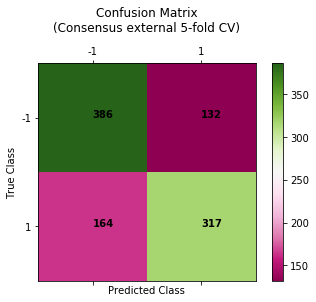

########################################
#   Unbalanced Statistical Parameters  #
########################################
Accuracy: 0.7
Area under the Curve (AUC): 0.7
########################################
#   Balanced Statistical Parameters    #
########################################
Correct Classification Rate (CCR): 0.7
Weighted Kappa:  0.41
########################################
#            Positive Class            #
########################################
Sensitivity (Se): 0.66
Positive Predictive Value (PPV): 0.71
########################################
#            Negative Class            #
########################################
Specificity (Sp): 0.75
Negative Predictive Value (NPV): 0.7
########################################
#     Other Statistical Parameters     #
########################################
Precision:  0.71
Recall:  0.66
F1:  0.68
########################################
#        Applicability Domain          #
##################################

In [31]:
run_statistics(moldf_global['Outcome'], moldf_global['Consensus'], label="Consensus external 5-fold CV", coverage=100)

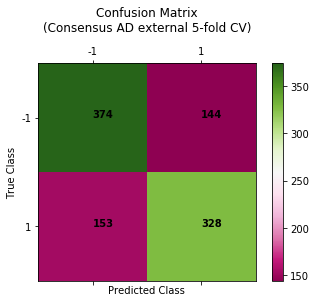

########################################
#   Unbalanced Statistical Parameters  #
########################################
Accuracy: 0.7
Area under the Curve (AUC): 0.7
########################################
#   Balanced Statistical Parameters    #
########################################
Correct Classification Rate (CCR): 0.7
Weighted Kappa:  0.4
########################################
#            Positive Class            #
########################################
Sensitivity (Se): 0.68
Positive Predictive Value (PPV): 0.69
########################################
#            Negative Class            #
########################################
Specificity (Sp): 0.72
Negative Predictive Value (NPV): 0.71
########################################
#     Other Statistical Parameters     #
########################################
Precision:  0.69
Recall:  0.68
F1:  0.69
########################################
#        Applicability Domain          #
##################################

In [32]:
coverage= (len(moldf_global['Consensus AD'])*100/len(moldf))
run_statistics(moldf_global['Outcome'], moldf_global['Consensus AD'], 
               label="Consensus AD external 5-fold CV", coverage=int(coverage))